In [1]:
import torch
import math
from SC_IPFP.torch.utils import NN, log_kde_pdf_per_point, silvermans_rule
from SC_IPFP.torch.sde_solvers_time import solve_sde_RK


from tqdm.notebook import tqdm

from torch import nn

import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt

In [2]:
from torch import nn
class NN(nn.Module):

    def __init__(self, input_dim=1,  weight_dim_list=[20,20,20]):
        super(NN, self).__init__()

        self.weight_dim_list = [input_dim] + weight_dim_list
        self.layers = [None for i in weight_dim_list]

        for i in range(len(weight_dim_list)):
            setattr(
                self,
                "f" + str(i),
                nn.Linear(
                    self.weight_dim_list[i], self.weight_dim_list[i + 1], bias=True
                )
            )
            self.layers[i]  = getattr(self, "f" + str(i))

            torch.nn.init.xavier_uniform(self.layers[i].weight)
    
    def get_var(self , other=None):
        return torch.tensor([[0]]).double()

    def forward(self, x, var=None):
        functerino = torch.tanh
        x_ = x.clone()
        for i_, layer in enumerate(self.layers[:-1]):
            try:
                x = functerino(layer(x))
            except:
                print(x.shape, i_, x_.shape)
                import pdb; pdb.set_trace()
                raise
        try:
            return (self.layers[-1](x))
        except:
            import pdb; pdb.set_trace()
            raise


In [3]:
def solve_sde_RK(alfa=None, beta=None, X0=None, dt=1.0, N=100, t0=0.0,
                theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(alfa=None, beta=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        alfa  : a  function with two arguments, the X state and the time
                defines the differential equation.
        beta  : a  function with two arguments, the X state and the time
                defines the stochastic part of the SDE.
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)
    
    """
    
#     print(X0)
       
    if alfa is None or beta is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape
    
    T = torch.tensor(dt * N).cuda()
    
    DWs  = torch.empty((n, N-1, d)).normal_(mean=0, std=1).cuda() * math.sqrt(dt)
    
    
    Y, ti = torch.zeros((n, N, d + 1)).double().cuda(), torch.arange(N).double().cuda()*dt + t0
    t0rep =  (
        t0 * torch.ones((X0.shape[0], 1)).double().cuda() if forwards
        else (T-t0) * torch.ones((X0.shape[0], 1)).double().cuda()
    )
#     Y[:, 0, :] =  torch.cat((X0, t0rep), axis=1 )
    Y = torch.cat((X0, t0rep), axis=1 )[:, None, :]

    N = int(N)
    
    T = dt * N
        
    for n in range(N-1):
        t = ti[n]
        a, DW_n = alfa(Y[:,n, :]),  DWs[:,n,:]
        newY = (  
            Y[:,n, :-1] + a * dt + beta * DW_n
        )
        
        trep = (
            t.repeat(newY.shape[0]).reshape(-1,1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1,1)
        )
        
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
        Y = torch.cat((Y,tocat) , dim=1)
    if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()
#     import pdb; pdb.set_trace()
    return ti, Y

In [4]:
def divergence(outputs, inputs):
    grads_ = torch.autograd.grad(
            outputs, inputs, torch.ones_like(outputs),
            retain_graph=True, create_graph=True
     )[0]
    return grads_[:,:,:-1].sum(dim=2)

In [5]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = None, rng_b = None, 
                nrng = None, number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, weight_decay = 0.9, create_network=None,
                log_prob=log_kde_pdf_per_point, optimizer=torch.optim.SGD, lrs = None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        with torch.cuda.device(0):
        
            self.X_0 = X_0.requires_grad_()
            self.X_1 = X_1.requires_grad_()

            self.H_0 = silvermans_rule(X_0)
            self.H_1 = silvermans_rule(X_1)

            _, self.dim = self.X_0.shape

            weights = weights + [self.dim]


            self.b_forward = NN(self.dim + 1, weights).double().cuda()
            self.b_backward = NN(self.dim + 1, weights).double().cuda()

            self.theta_f = list(self.b_forward.parameters())
            self.theta_b = list(self.b_backward.parameters())

            self.sigma = sigma_sq

            self.optimizer_f = optimizer(
                self.theta_f, lr=step_size, weight_decay=weight_decay
            )

            self.optimizer_b = optimizer(
                self.theta_b, lr=step_size, weight_decay=weight_decay
            )
            
            m = 0.1
            lr_lambda = lambda epoch : 1.0 / (1.0 + lrs * epoch)


            self.lrs_f  = torch.optim.lr_scheduler.LambdaLR(self.optimizer_f, lr_lambda, last_epoch=-1)
            self.lrs_b  = torch.optim.lr_scheduler.LambdaLR(self.optimizer_b, lr_lambda, last_epoch=-1)

            num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
            self.num_batches_f = num_complete_batches_f + bool(leftover_f)

            num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
            self.num_batches_b = num_complete_batches_b + bool(leftover_b)

            self.first_iter_fac = 0.0

            self.log_prob = log_prob

            self.burn_in = False
    
    def data_stream(self, forward=True):
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = torch.randperm(X.size()[0])
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
    def loss_for_trajectory(self, Xt, forwards):
        n_, *_ = Xt.shape
        
#         if not forwards :
#             Xt = Xt.flip(1)
        
        if forwards:
            b_minus  = self.b_backward.forward( Xt)
            b_plus = self.b_forward.forward(Xt)
            div = divergence(b_minus, Xt)
        else:
            b_minus  = self.b_backward.forward(Xt)
            b_plus = self.b_forward.forward(Xt) * self.first_iter_fac 
            div = -divergence(b_plus, Xt) * self.first_iter_fac 

            
        sign = 1.0 if forwards else -1.0
        
        time_integral = (sign *  (b_plus - b_minus))**2 * self.dt 
        out =  0.5 * time_integral.sum(dim=(1,2))  - (div.sum(dim=(1)) *  self.dt )
        
        return out


    def inner_loss_jit(self, batch,  
                       batch_terminal_empirical,
                       forwards):
        
        b = (
            self.b_forward.forward
            if forwards else (lambda X: -self.b_backward.forward(X))
        )
        
        t, Xt, *W = self.sde_solver(
            b, self.sigma, batch, self.dt, 
            self.number_time_steps, 0,
            None, False, forwards
        )
        Ht = silvermans_rule(Xt[:,-1,:-1])
        H = silvermans_rule(batch_terminal_empirical)
        
        main_term = self.loss_for_trajectory(Xt, forwards)

        if not self.burn_in:
#             xx = torch.linspace(-30, 30 , 1000).reshape(-1,1).double().cuda()
#             yy = self.log_prob( xx, batch_terminal_empirical, H)  
#             plt.plot(
#                 xx.detach().cpu().numpy(),
#                 np.exp(yy.detach().cpu().numpy())
#             )
#             plt.show()
            cross_entropy = -self.log_prob( Xt[:,-1,:-1], batch_terminal_empirical, H)             
        else:
            cross_entropy = -self.log_prob(batch_terminal_empirical, Xt[:,-1,:-1], Ht)

        J = torch.mean(main_term +  2.0 * cross_entropy )
        J = torch.squeeze(J)
        return J
    
    def inner_loss(self, batch, forwards=True):
        
        if self. burn_in:
            self.batch_terminal_empirical_burn = next(self.data_stream(forward=forwards))
            self.H_burn = self.H_0 if forwards else self.H_1
#         else:
        batch_terminal_empirical = next(self.data_stream(forward=not(forwards)))
        H = self.H_1 if forwards else self.H_0

        return self.inner_loss_jit(
            batch, batch_terminal_empirical,
            forwards
        )

    def closure(self, X, forwards=True):
        """
        Close method required for pytorches CG and LBFGS optimizers
        :params X[torch.tensor]: nxdim  torch tensor representing dataset
        """
        
        opt = self.optimizer_f if forwards else self.optimizer_b
        
        opt.zero_grad()
        loss = self.inner_loss(X, forwards)
        loss.backward()
        return loss
    
    
    def fit(self, IPFP_iterations=10, sub_iterations=10, plot=False, burn_iterations=7):     
        
        name = str(self.optimizer_f).lower()
        bfgs_cg_flag  = "bfgs" in name or "cg" in name
        close_f, close_b =  [], []

        
        
        if plot: self.plot_trajectories()
        
        self.first_iter_fac = 0.0
        if burn_iterations > 0 : self.burn_in = True
            
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_b, loss_f = [], []
        for i in tqdm(range(IPFP_iterations + burn_iterations)):
            
            if i == burn_iterations:
                self.burn_in = False
                self.first_iter_fac = 0.0
            
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    batch_b =  next(batches_b)
                    
                    if bfgs_cg_flag:
                        close_b = [lambda : self.closure(batch_b, False)]
                    lossb = self.inner_loss(
                        batch_b, False
                    )
                    lossb.backward()
                    self.optimizer_b.step(*close_b)
                    self.lrs_b.step()
                print(f"loss b {lossb}")
            loss_b.append(lossb)

            self.first_iter_fac = 1.0
       
            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    batch_f =  next(batches_f)
                    if bfgs_cg_flag:
                        close_f = [lambda : self.closure(batch_f, True)]
                    lossf = self.inner_loss(
                        batch_f, True
                    )
                    
                    lossf.backward()
                    self.optimizer_f.step(*close_f)
                    self.lrs_f.step()
  
                print(f"loss f {lossf}")
            loss_f.append(lossf)


            self.loss_f = loss_f
            self.loss_b = loss_b
            if plot: self.plot_trajectories()

        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
        
    def plot_trajectories(self):
        bb = lambda X: -self.b_backward(X)

        t, Xts = self.sde_solver(
            self.b_forward.forward, self.sigma,
            self.X_0, self.dt,  self.number_time_steps, 0.0,
            self.theta_f, False, True
        )
        t_, Xts_ = self.sde_solver(
            bb, self.sigma, 
            self.X_1, self.dt, self.number_time_steps, 0.0, 
            self.theta_b, False, False
        )
        
        fn = 14
        fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
        axs[1].set_xlabel("$t$", fontsize=fn)
        axs[1].set_ylabel("$x(t)$", fontsize=fn)
        axs[0].set_ylabel("$x(t)$", fontsize=fn)

        tt = axs[1].get_xticks()
        axs[1].set_xticks(tt.flatten() )
        axs[1].set_xticklabels(list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1])

        for i in range(n):
            label = "$\mathbb{Q}$: Forward process" if i == 0 else None
            axs[0].plot(t.cpu().flatten(), Xts[i,:,:-1].detach().cpu().numpy().flatten(), 'b', alpha=0.03,  label=label)


        for i in range(n):
            label = "$\mathbb{P}$: Reverse process" if i == 0 else None
            axs[1].plot(t_.cpu().flatten(), Xts_[i,:, :-1].detach().cpu().numpy().flatten(), 'r', alpha=0.03, label=label)

        axs[1].legend(fontsize=fn)
        axs[0].legend(fontsize=fn)

        plt.show()    
    
    #     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
            

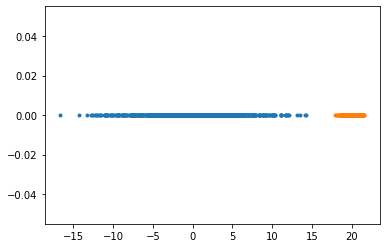

In [6]:
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n = 900
n_2 = int(n * 1.0 / 3)
n_2 = int(n * 1.0 / 2.0)


X1 = 5 * npr.randn(n).reshape(-1,1) - 0
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 20
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) + 20
# X23 =  0.6 * npr.randn(n_2).reshape(-1,1) + 20

X2 = np.concatenate((X21, X22), axis=0)
X1, X2 = X2, X1

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

with torch.cuda.device(0):

    X1 = torch.tensor(X1).cuda()
    X2 = torch.tensor(X2).cuda()

In [8]:


torch.cuda.manual_seed_all(10)
torch.manual_seed(10)

c = cIPFP(
    X1, X2,  number_time_steps=100, batch_size=900 ,
    step_size=1e-2, weights=[500], rng = None,
    optimizer=torch.optim.Adagrad, lrs = 0.01, weight_decay=0
)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


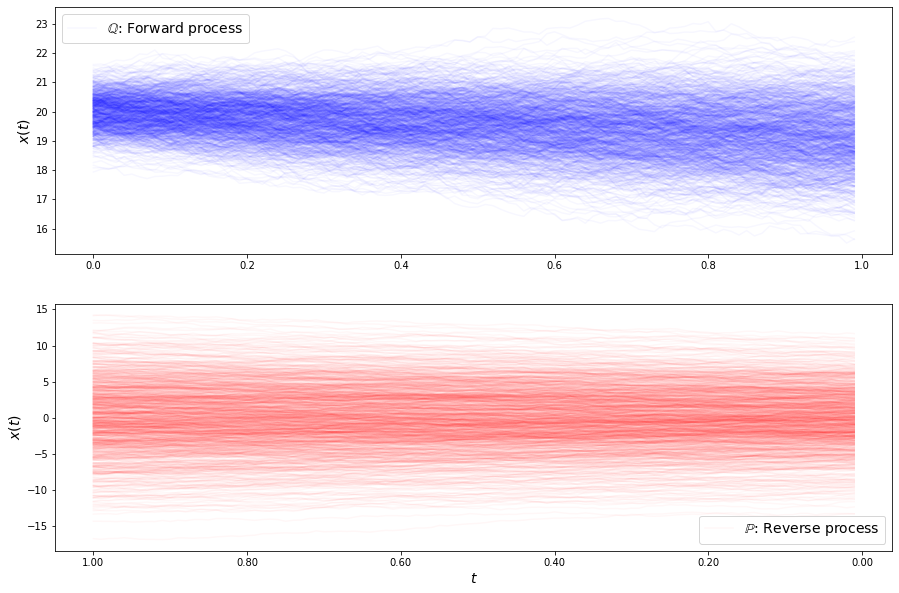

Widget Javascript not detected.  It may not be installed or enabled properly.


loss b 4273.514818910775
loss b 3510.928219863593
loss b 3001.46870407243
loss b 2586.84117977483
loss b 2162.628608222261
loss b 1786.861241495821
loss b 1464.9483337565875
loss b 1201.070749455014
loss b 989.514363853288
loss b 859.2955461996847
loss b 782.0346407229073
loss b 743.273250658027
loss b 681.376051408444
loss b 620.3681780832273
loss b 561.299955624804
loss b 494.3393462714833
loss b 427.748810715668
loss b 377.15855323162026
loss b 344.2494747276546
loss b 325.24849307988137
loss b 320.44051798326836
loss b 320.1961603798823
loss b 316.4370457376941
loss b 322.1701846707413
loss b 316.1770794180226
loss b 314.07216529726463
loss b 307.27062563494025
loss b 293.5179768317683
loss b 280.0183381868088
loss b 264.8947087747503
loss f 79.77661588288564
loss f 22.393036895835884
loss f 17.573134174844615
loss f 20.45950300452964
loss f 25.5456852433386
loss f 30.581617060522376
loss f 33.936527526974324
loss f 35.02656250222928
loss f 33.94733757983003
loss f 31.4084862552884

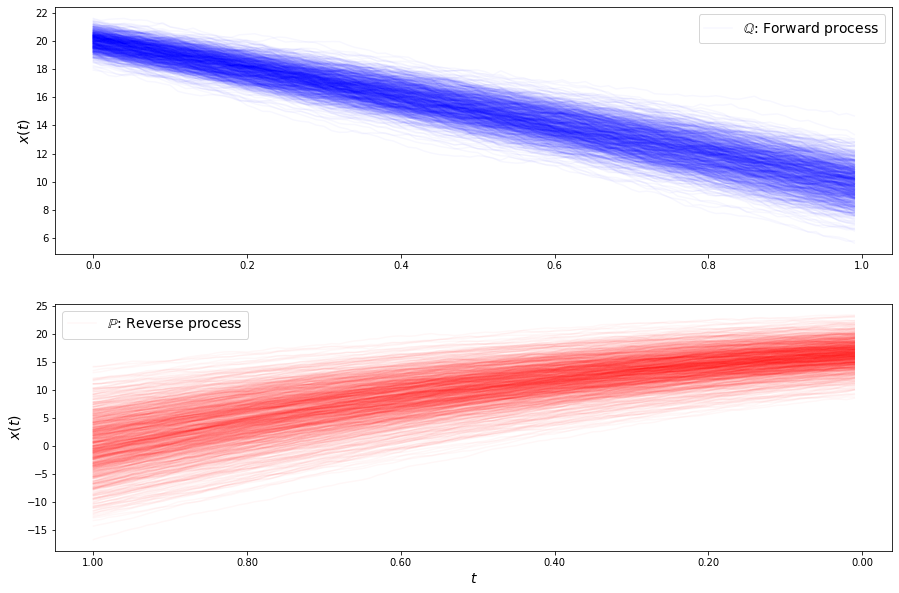

loss b 148.3731023309848
loss b 140.41265717366522
loss b 126.35999354424699
loss b 117.98365360281839
loss b 110.96648915714944
loss b 109.12699805180583
loss b 108.49124157435176
loss b 114.18104936643341
loss b 119.54071982354252
loss b 126.13708317746735
loss b 130.6403471204708
loss b 131.69609232228564
loss b 128.7107505651687
loss b 122.3708742996986
loss b 116.36521423992602
loss b 108.61375763960967
loss b 106.43837825189983
loss b 102.58849361034449
loss b 103.77977966978312
loss b 105.1160026149526
loss b 108.83560485030097
loss b 111.24621279820448
loss b 117.4234907222888
loss b 121.34939236998024
loss b 123.70692398517956
loss b 127.487563602625
loss b 127.3053680961955
loss b 127.38963390282366
loss b 126.90716228375337
loss b 124.31461709455861
loss f 23.691745004912654
loss f 28.837040661748084
loss f 35.22937204119973
loss f 42.85404659841308
loss f 50.578694452681994
loss f 59.004242157987875
loss f 66.75021210406666
loss f 73.72574351843805
loss f 79.60921373073441


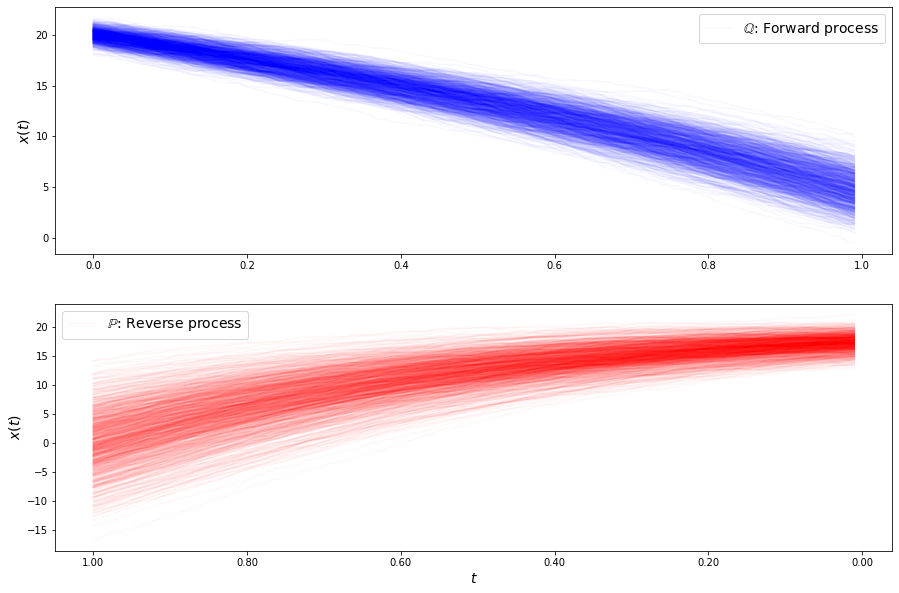

loss b 71.16330875388276
loss b 55.05011982604719
loss b 49.123772885761475
loss b 49.94779239494406
loss b 59.86342171940028
loss b 74.66806379821548
loss b 99.77466841164473
loss b 128.25382412955364
loss b 150.09732196964387
loss b 165.07214914279865
loss b 167.71960340044674
loss b 155.31227307421148
loss b 133.10593221921638
loss b 111.77284424658144
loss b 88.90349447370477
loss b 73.02952593485155
loss b 62.485633407667656
loss b 56.86181013554635
loss b 54.44445734227189
loss b 53.986081094182104
loss b 56.64586088792723
loss b 60.78829611018872
loss b 65.83018774853481
loss b 71.309359621818
loss b 78.0575069936421
loss b 84.87435096735469
loss b 93.44425649933447
loss b 101.91320818465552
loss b 108.76324944369367
loss b 114.15192870751521
loss f 36.35784330158661
loss f 34.09654415531864
loss f 31.84867997842009
loss f 29.862712714422546
loss f 28.11025037201483
loss f 26.40030294645804
loss f 24.82926921810348
loss f 23.530159444429536
loss f 22.213887272895672
loss f 21.14

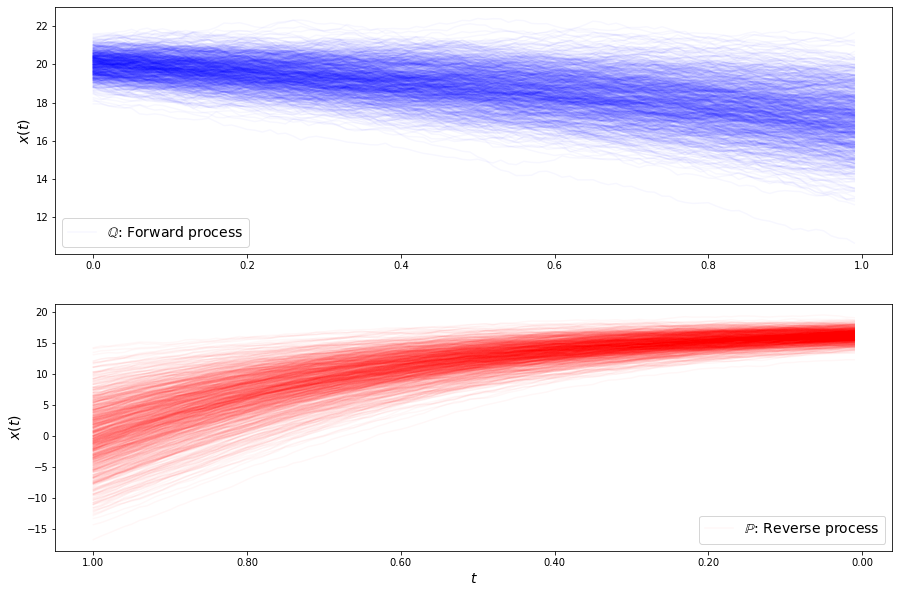

loss b 101.34642818006881
loss b 98.89124076987643
loss b 96.91628791678777
loss b 93.2016240595034
loss b 89.91150545347473
loss b 86.42647677811331
loss b 81.63780768547804
loss b 80.2285222581411
loss b 77.66082955716746
loss b 75.64421424935611
loss b 73.91109519705651
loss b 72.19962500398287
loss b 71.87001107835601
loss b 71.89134990732822
loss b 73.02277487576914
loss b 73.00675258778168
loss b 74.067475126814
loss b 75.53948377060911
loss b 76.751971009387
loss b 78.38680103001515
loss b 80.39467928260262
loss b 82.145037712737
loss b 83.36784471769441
loss b 85.39762738368957
loss b 87.00823439130329
loss b 88.91987194524795
loss b 90.82118377744449
loss b 92.12660282037022
loss b 92.1426265879833
loss b 93.4676329474611
loss f 65.17825527535193
loss f 54.82369265342829
loss f 46.677774990349846
loss f 41.14824458544438
loss f 36.93566485749673
loss f 33.67208038642202
loss f 30.537204008423316
loss f 27.955318203358992
loss f 25.75952322477947
loss f 23.467264874957028
loss 

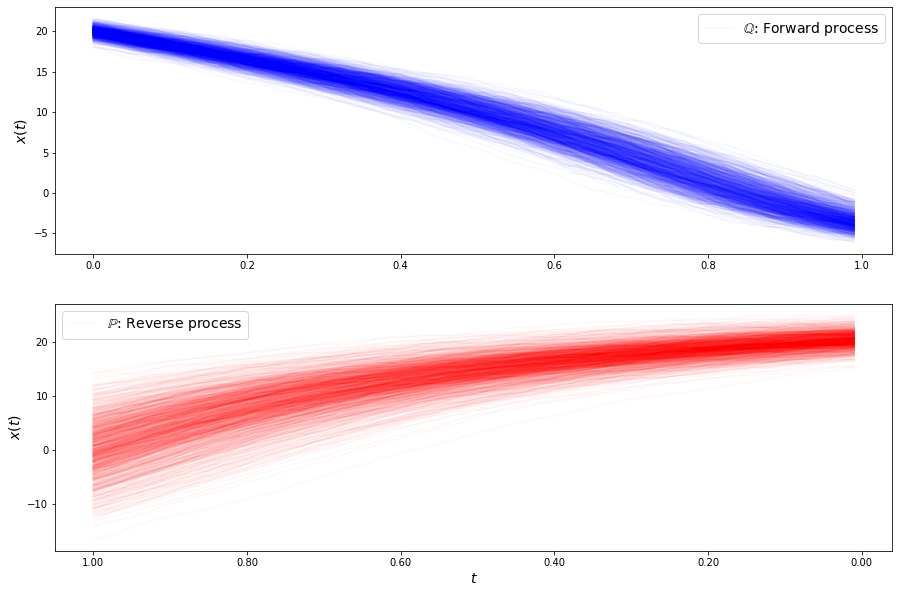

loss b 35.91011835892146
loss b 36.5345623211087
loss b 36.34834322816934
loss b 36.906141985759334
loss b 37.15597929806586
loss b 37.2864311032968
loss b 37.66686030581155
loss b 38.096548415809025
loss b 38.63336193583589
loss b 38.81993644762738
loss b 39.34044943804306
loss b 39.59670184245005
loss b 39.95936368494396
loss b 40.0113151070463
loss b 40.22307880148827
loss b 40.47249021823231
loss b 40.49367830125246
loss b 40.93137752733933
loss b 40.927891464079224
loss b 41.174078432758066
loss b 41.309244401157045
loss b 41.538749385549785
loss b 41.58712459600106
loss b 41.1597202180228
loss b 40.771773283029376
loss b 40.79129451178045
loss b 40.72109819536809
loss b 40.709354127669506
loss b 40.55136260276043
loss b 40.16730642435495
loss f 60.65200357451733
loss f 58.506395690448734
loss f 57.642009721972386
loss f 56.32433209474187
loss f 54.6164163419116
loss f 53.02950323184638
loss f 49.97216256603986
loss f 47.87082187395053
loss f 45.158795629722974
loss f 42.829996671

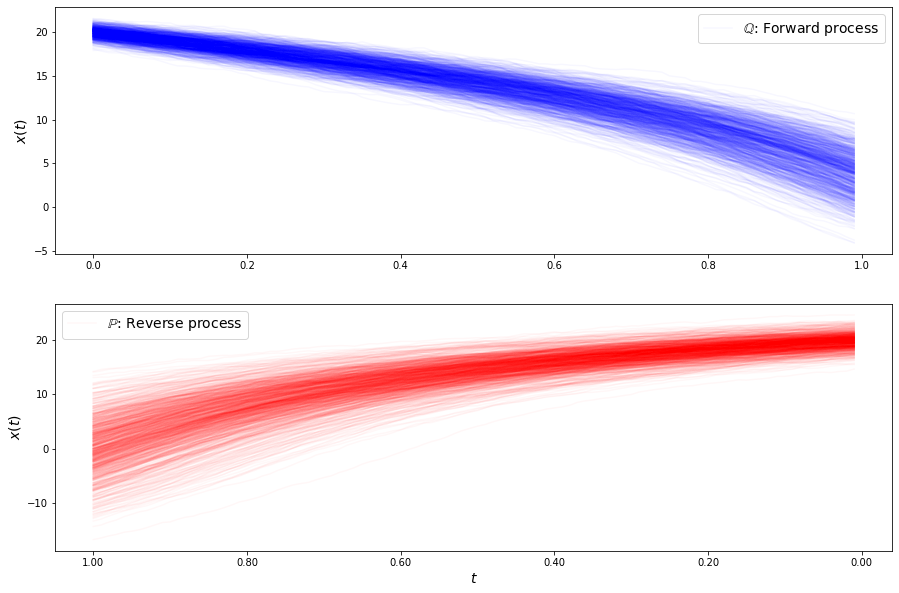

loss b 21.25694480783624
loss b 21.200234643100558
loss b 21.309501616696732
loss b 21.946813622141697
loss b 22.134729346367745
loss b 22.037011334279594
loss b 23.027599059250242
loss b 23.249893708455982
loss b 24.24709659320296
loss b 24.559784088022244
loss b 24.905044063399576
loss b 25.749141011252654
loss b 25.50845533635084
loss b 25.933477622915696
loss b 26.30448344421385
loss b 26.554735107313874
loss b 26.7366226122331
loss b 26.808803138826107
loss b 26.839596781831506
loss b 27.145539038008078
loss b 27.27801575839319
loss b 27.200848630933624
loss b 26.516381420221602
loss b 26.674622800095232
loss b 25.54666115377285
loss b 25.69796534720404
loss b 25.232063141757767
loss b 25.09161375421515
loss b 24.281156793785517
loss b 23.766835114378125
loss f 10.133706235955648
loss f 10.31028103187187
loss f 10.4360531783721
loss f 10.578330390851441
loss f 10.805954371206129
loss f 11.091409477625945
loss f 11.439188347819462
loss f 11.731925776559194
loss f 12.120988055814802

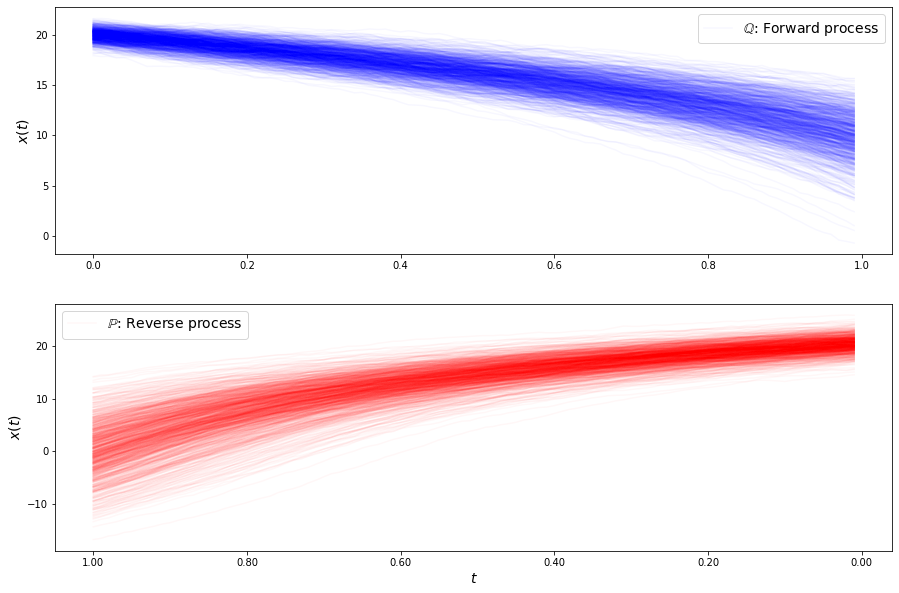

loss b 27.38262745999174
loss b 25.54452919299521
loss b 24.17768236830184
loss b 23.261670925359
loss b 22.141907827011444
loss b 21.71941899436117
loss b 21.03675066945595
loss b 20.423096801034546
loss b 19.957230061199425
loss b 20.00539726551246
loss b 20.119379563849453
loss b 20.60445851847977
loss b 20.81122952356051
loss b 20.55811179093642
loss b 20.975117606110917
loss b 22.03926592516553
loss b 22.403998346282556
loss b 23.896147579299303
loss b 24.71424219033253
loss b 25.215625043832247
loss b 26.187728913029776
loss b 26.299744245833594
loss b 27.72089589921539
loss b 28.708538773806303
loss b 30.27612508206258
loss b 32.55417517383376
loss b 32.539068848262836
loss b 33.29588636396534
loss b 34.63807998575364
loss b 35.08565001218674
loss f 7.26897380821077
loss f 7.295373974406289
loss f 7.199103438458345
loss f 7.201182064528055
loss f 7.2145746994551185
loss f 7.124675817116017
loss f 7.219211816288257
loss f 7.143051382559362
loss f 7.003493232095171
loss f 6.944939

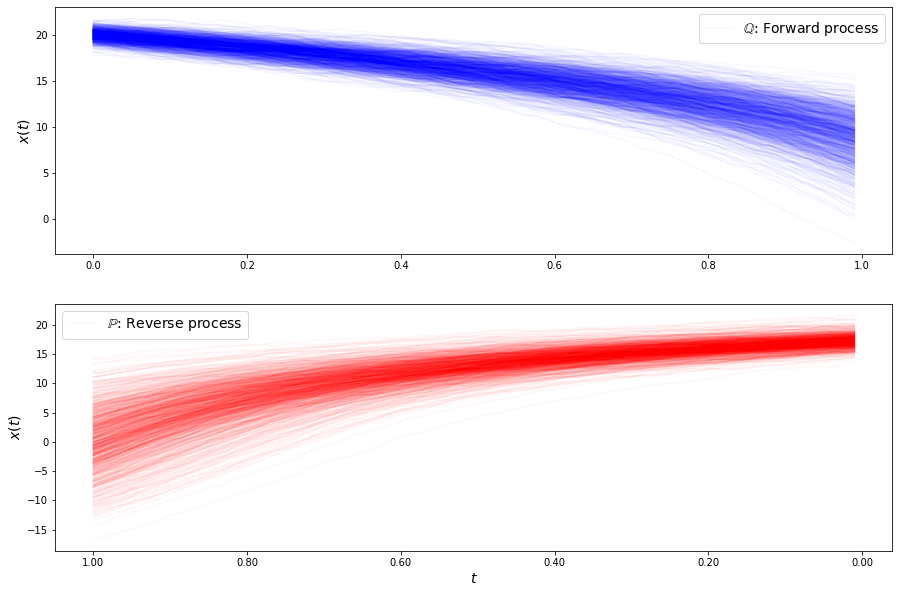

loss b 32.34368271867828
loss b 32.700308831916544
loss b 32.856015432111214
loss b 32.87918582250614
loss b 33.7496280827378
loss b 32.79363587649143
loss b 33.19956907876474
loss b 33.06052951037883
loss b 32.0771635249076
loss b 31.252737926148075
loss b 31.59991464353302
loss b 28.671583323939544
loss b 29.176385287981233
loss b 28.462454247578094
loss b 27.637203192410396
loss b 26.743846176799938
loss b 25.990077150965426
loss b 25.536101182109345
loss b 24.811463569716004
loss b 22.77734013752354
loss b 22.81935708496856
loss b 21.126097346388246
loss b 20.44180448731934
loss b 19.79558778466712
loss b 18.32013506343902
loss b 18.656428848007064
loss b 17.329457013968497
loss b 16.94488074992782
loss b 16.27337022892867
loss b 15.77409822531201
loss f 5.699834895963201
loss f 5.643639443433701
loss f 5.624422894623583
loss f 5.545685051292207
loss f 5.464222721906327
loss f 5.378693545321437
loss f 5.350499119147793
loss f 5.2314690627478395
loss f 5.16900516494208
loss f 5.0351

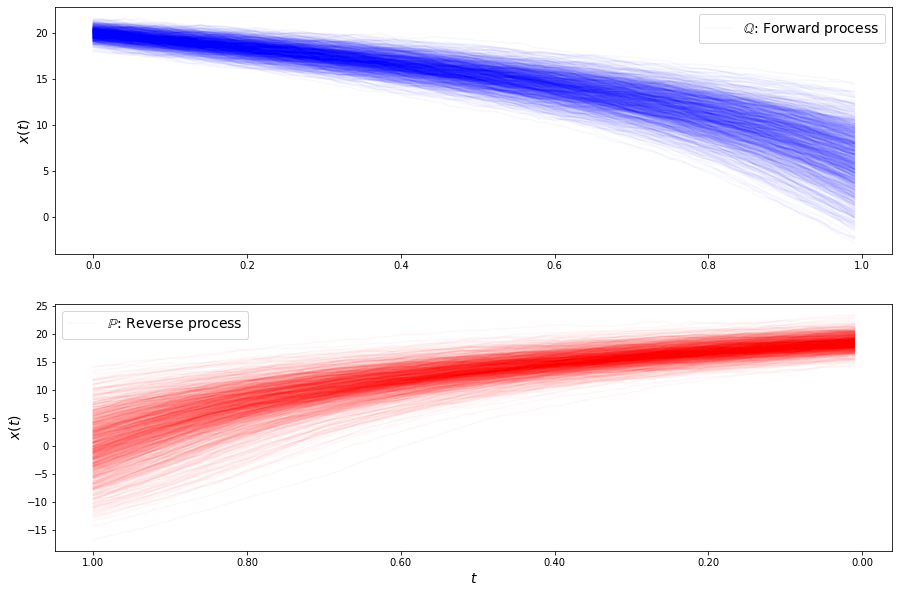

loss b 12.59009076240855
loss b 12.133096693968163
loss b 11.281190262254942
loss b 11.289603568244049
loss b 10.76537144532695
loss b 10.476050640584287
loss b 10.083891495727004
loss b 10.223710906742541
loss b 9.836810249133752
loss b 9.798565025932332
loss b 9.77690305416855
loss b 9.74529542714224
loss b 10.107560347558666
loss b 10.047103722941507
loss b 10.002293246846364
loss b 10.011030164906366
loss b 10.198732238735154
loss b 10.637787029361306
loss b 11.578337979208406
loss b 11.642221078918105
loss b 11.188468859252614
loss b 12.44323110986156
loss b 13.139808650181887
loss b 13.204728016197715
loss b 13.392995162495412
loss b 13.535965621246365
loss b 14.723810071036647
loss b 14.607161710214312
loss b 15.539777865803783
loss b 16.121565265635635
loss f 8.09839694394548
loss f 7.717603064880892
loss f 7.415348165470749
loss f 7.002102339736625
loss f 6.785845353244432
loss f 6.341741791108311
loss f 6.012527841898849
loss f 5.681646597559727
loss f 5.445941099549395
loss 

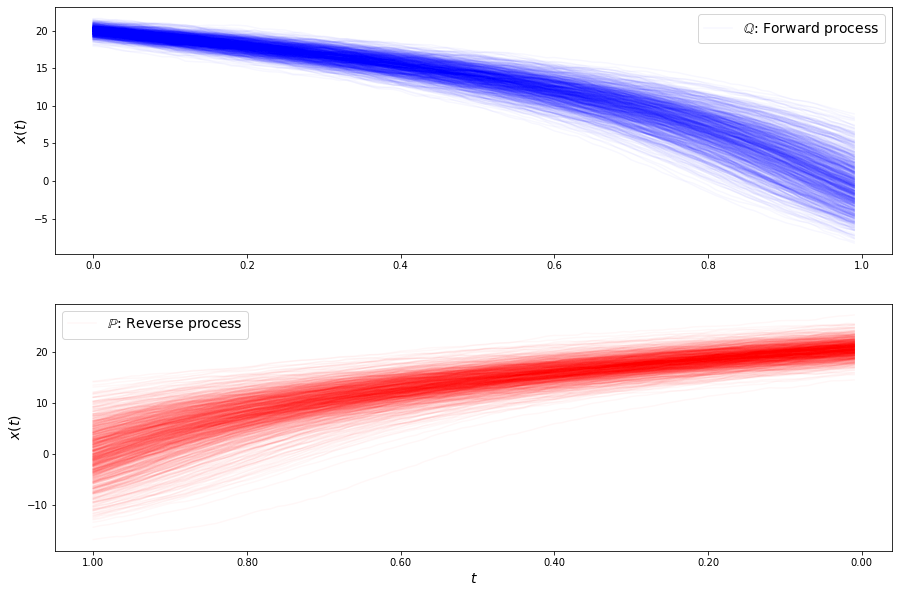

loss b 11.572926945350392
loss b 12.474416152509644
loss b 12.346239687422711
loss b 12.48411854049241
loss b 12.55795497609871
loss b 12.80945052613389
loss b 13.41625993356286
loss b 13.808288310928857
loss b 14.298434532977705
loss b 13.952684147450759
loss b 14.339103401071148
loss b 13.277663933905643
loss b 14.988032116361575
loss b 14.390897977710157
loss b 14.372309809826902
loss b 14.140175385353269
loss b 13.420658328226216
loss b 14.251254129179602
loss b 14.265638294827198
loss b 12.965586370959267
loss b 14.060156629582657
loss b 13.348074140452043
loss b 14.16524760078717
loss b 13.2846114071859
loss b 13.403160031820128
loss b 13.594788941696677
loss b 13.620609891519102
loss b 12.58278667963732
loss b 11.593597991526826
loss b 11.898119352853332
loss f 3.547889124455954
loss f 3.828415080394863
loss f 3.863648045610479
loss f 3.9437267141217953
loss f 4.08397117831276
loss f 4.416997805204777
loss f 4.459852988321664
loss f 4.552511448170916
loss f 4.926122892907494
los

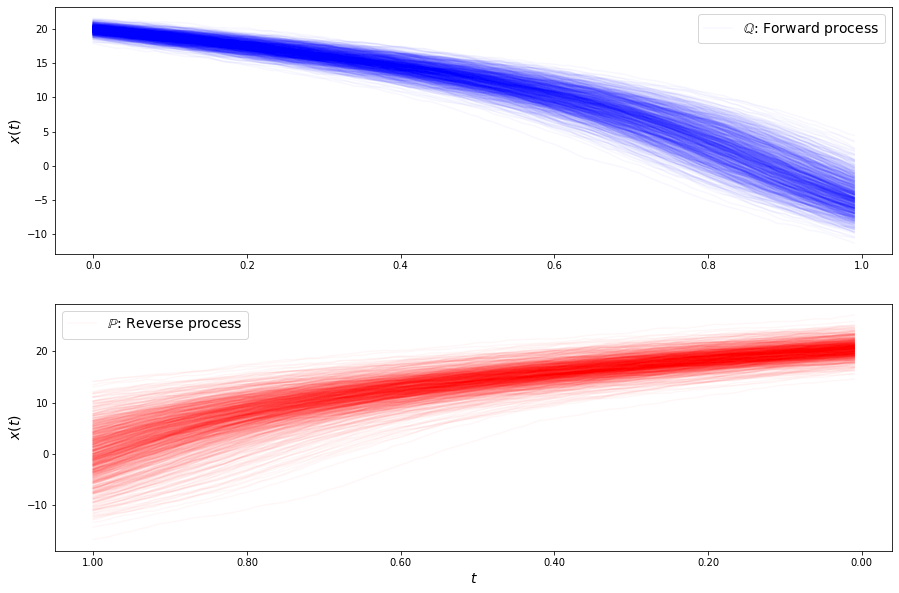

loss b 14.054526180831113
loss b 14.225050064081726
loss b 15.017970468309551
loss b 13.785793618521579
loss b 13.288054388417033
loss b 14.532867336588104
loss b 13.859214689845857
loss b 14.64759786300561
loss b 14.568754946078744
loss b 13.75901497357941
loss b 12.793107308540002
loss b 12.98221428533684
loss b 13.447446361195041
loss b 14.242412022666946
loss b 13.263380317597813
loss b 14.313695152388028
loss b 13.460296662246929
loss b 13.416490440481917
loss b 13.023496225990923
loss b 12.980863423425363
loss b 13.59680912771312
loss b 13.462206272916072
loss b 13.673902502094831
loss b 13.176058939523427
loss b 14.463789522651911
loss b 13.519760665006071
loss b 13.403029680347395
loss b 13.378797158177866
loss b 13.232445113796224
loss b 13.223617017236265
loss f 9.815606555028216
loss f 9.814005114541736
loss f 9.567111129092648
loss f 9.365146269774437
loss f 9.313462384885327
loss f 9.090540950524815
loss f 8.938535170467565
loss f 8.83910402762134
loss f 8.73272251103013
l

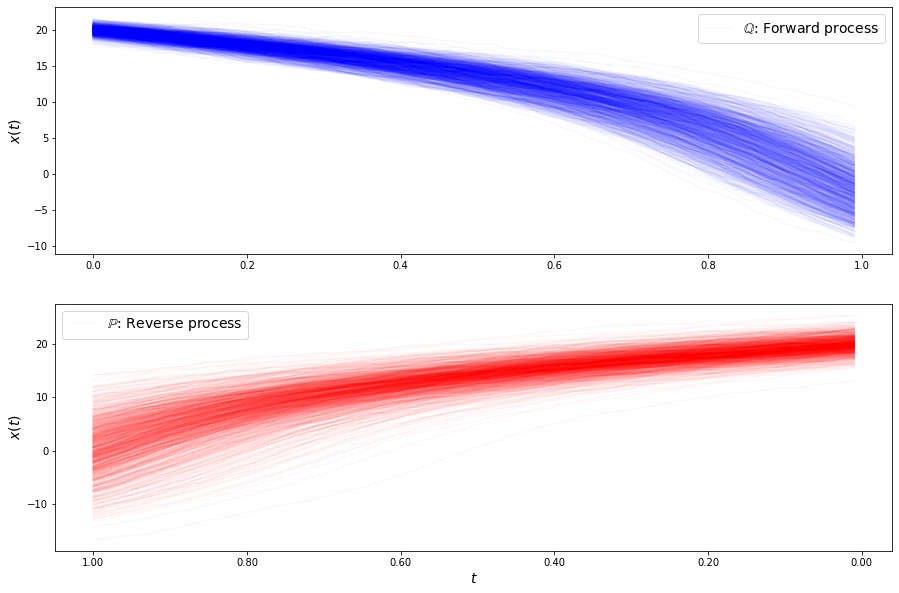

loss b 9.787712028980943
loss b 10.265498344592581
loss b 9.266448141939435
loss b 9.684682690149552
loss b 9.800696651625147
loss b 9.350400709873197
loss b 10.236888732212083
loss b 9.651040628178833
loss b 10.221080596127845
loss b 10.000142463080211
loss b 9.068381629684682
loss b 10.161988813190879
loss b 9.815903501256063
loss b 9.648989759707094
loss b 9.404280471555472
loss b 9.210093599920816
loss b 9.544441230584152
loss b 9.830966093666312
loss b 9.675764411460973
loss b 8.998232070682255
loss b 9.415519123806865
loss b 9.128517048738614
loss b 9.47090446145285
loss b 9.67611202162196
loss b 9.273905193625765
loss b 9.418809563729216
loss b 9.415205548906087
loss b 9.68808958151357
loss b 9.938196749995713
loss b 8.72967984711138
loss f 4.6708292952260795
loss f 4.409861352571401
loss f 4.234756093805512
loss f 4.079224295561044
loss f 3.8956974845097463
loss f 3.752112340854011
loss f 3.580677818537119
loss f 3.4489361404923264
loss f 3.391566296383636
loss f 3.250424631532

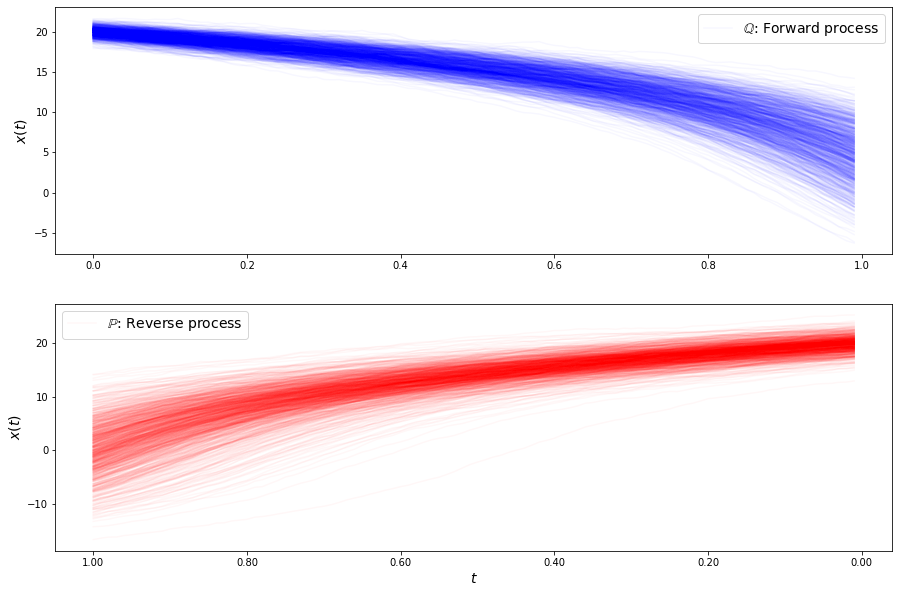

loss b 7.83155625710726
loss b 7.920174863324207
loss b 8.46959986016902
loss b 7.573550830076706
loss b 7.526197572424216
loss b 7.3604746316390814
loss b 7.555130411830517
loss b 7.376721875257412
loss b 7.540446904272623
loss b 7.436916427077029
loss b 7.100138754828106
loss b 7.542335315906413
loss b 7.864715590028768
loss b 7.530987571516992
loss b 7.430670245803722
loss b 8.091055251811392
loss b 7.58054209231862
loss b 7.184033752477304
loss b 7.116111112433742
loss b 7.86418482269312
loss b 7.310790341502997
loss b 7.319761812682629
loss b 7.845948606824267
loss b 7.481973592563227
loss b 7.282618475261753
loss b 7.3553684072365435
loss b 7.082532143154575
loss b 7.4083765723356105
loss b 6.9363494968944375
loss b 6.76260194252495
loss f 3.56577969777133
loss f 3.6958500374302012
loss f 3.7449851798795715
loss f 3.8872114776709887
loss f 4.043658811826684
loss f 4.194981118538513
loss f 4.294484318550368
loss f 4.412400810258275
loss f 4.576070176331192
loss f 4.761368383055049

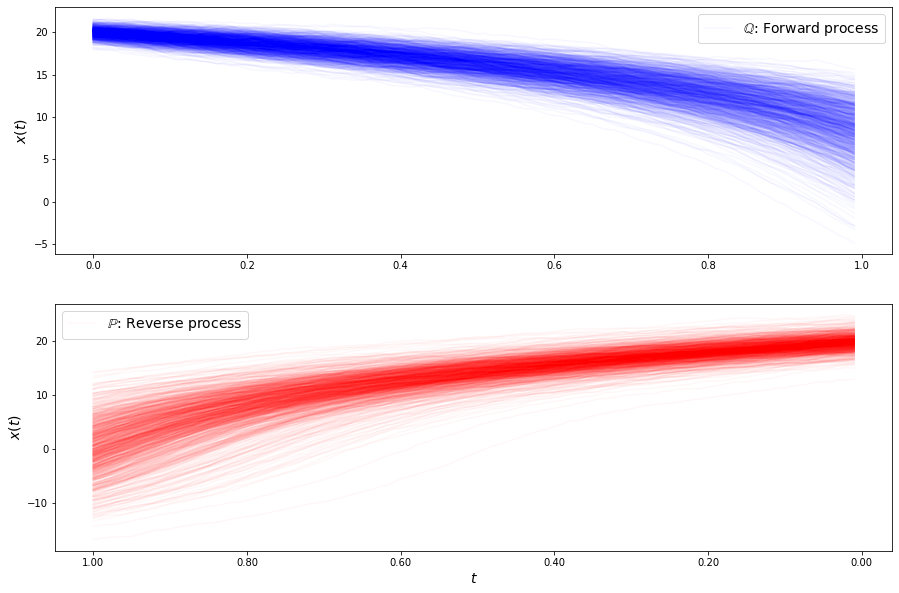

loss b 9.22670466802453
loss b 9.158524827119262
loss b 8.99001641996112
loss b 8.615489396655212
loss b 8.95461052549238
loss b 8.726989196236925
loss b 8.902073869813403
loss b 9.02392316894904
loss b 8.201218474538239
loss b 8.10272263993207
loss b 8.478840250735686
loss b 9.204056856798678
loss b 8.315447695616971
loss b 8.58170347652829
loss b 8.698968687873705
loss b 8.031408643386778
loss b 8.414043755304135
loss b 8.549873118497633
loss b 8.504377916295494
loss b 8.603371102692181
loss b 7.84704749801491
loss b 8.467151803733092
loss b 8.308799515383066
loss b 8.037079183625277
loss b 8.402219464207421
loss b 8.335404576858569
loss b 7.857257862410773
loss b 8.083889607840797
loss b 8.148393004595421
loss b 8.30287303718346
loss f 5.601584356826307
loss f 5.562678656545261
loss f 5.626464370360541
loss f 5.628958569736391
loss f 5.632484995302124
loss f 5.5466903591436125
loss f 5.59063002412899
loss f 5.515332213054429
loss f 5.521491745185987
loss f 5.579302861117915
loss f 5

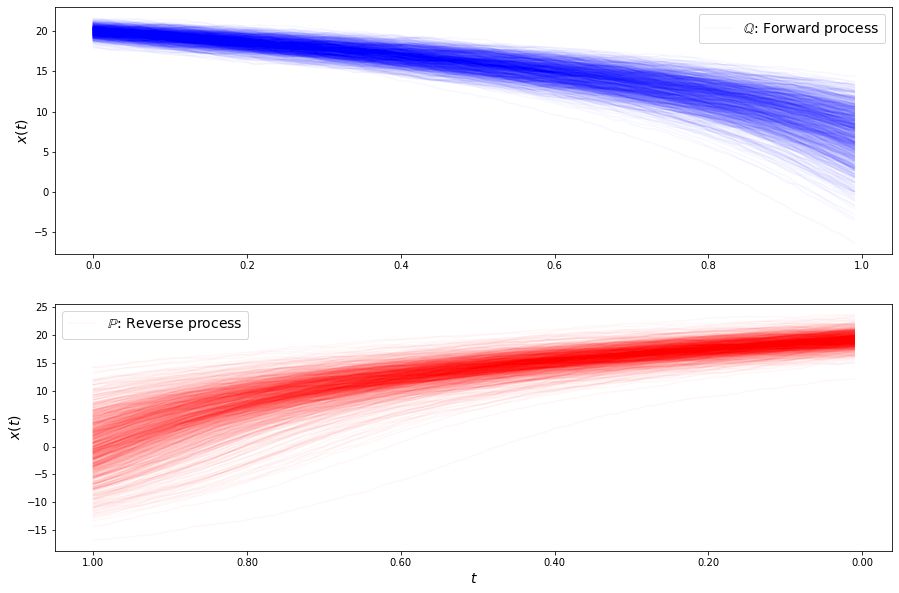

loss b 7.856097494771881
loss b 8.00725131788412
loss b 7.697653060031644
loss b 8.047459374500963
loss b 7.880192127109486
loss b 7.949085553752559
loss b 7.514394446998659
loss b 7.7859981696778995
loss b 8.26726491892464
loss b 8.41257377110999
loss b 8.07843907303832
loss b 8.466726557679415
loss b 8.381117095741192
loss b 7.979806665686747
loss b 8.25964632692439
loss b 8.592433018771727
loss b 8.92829394091947
loss b 8.92198012115104
loss b 8.821250157263107
loss b 8.639636456202311
loss b 8.871170449202637
loss b 8.824839139362338
loss b 8.148054443266881
loss b 9.112883938997918
loss b 8.887669269300387
loss b 8.901592953325919
loss b 9.309445069559311
loss b 8.761913136605033
loss b 8.657291722374687
loss b 9.143435736231224
loss f 4.01280778983666
loss f 4.02032324988764
loss f 3.9946397032112473
loss f 3.8737283547823944
loss f 3.9918558718055093
loss f 3.8050052007849122
loss f 3.8063096093156044
loss f 3.6916052614327604
loss f 3.663375352138977
loss f 3.719224697933028
lo

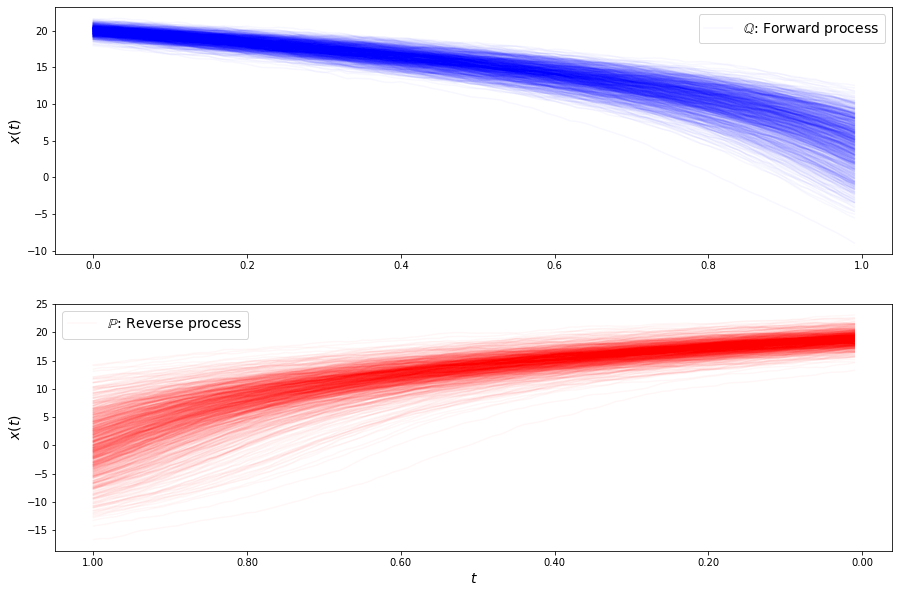

loss b 9.532858196853464
loss b 9.421869258011592
loss b 9.297051684514411
loss b 9.340627876262847
loss b 9.189598810876236
loss b 9.76852460094178
loss b 9.355017579533593
loss b 9.708600879466788
loss b 9.89000238040502
loss b 9.816779552641892
loss b 9.896346983604229
loss b 9.603827026544625
loss b 9.658266526211316
loss b 9.58565090538062
loss b 9.724778287409853
loss b 9.834731154996149
loss b 9.574194397861142
loss b 9.67425846006304
loss b 9.624664420093406
loss b 9.808233796136074
loss b 9.391070973745267
loss b 9.311692657970738
loss b 9.353535192682882
loss b 9.161065443568782
loss b 9.278945661761032
loss b 9.508323010733974
loss b 9.4827530021533
loss b 9.308856967521926
loss b 9.019558945700043
loss b 9.541147672955722
loss f 3.1358570117879636
loss f 3.1059137788823206
loss f 3.0336043724229094
loss f 3.07802978842499
loss f 3.0808494205540327
loss f 3.0903726086042163
loss f 3.161462791902095
loss f 3.073944260815788
loss f 3.158746797070406
loss f 3.1151965636392926
l

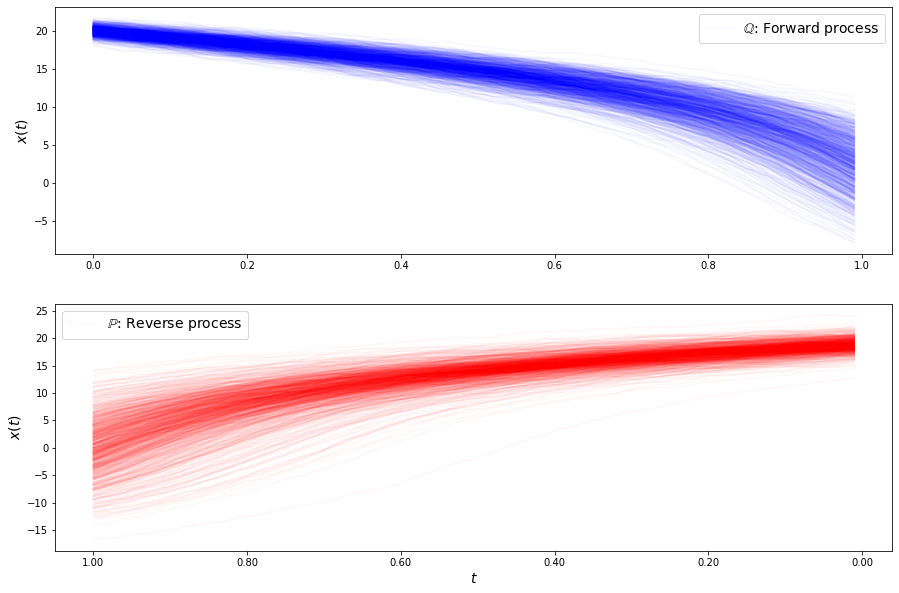

loss b 10.023759149454943
loss b 9.729299263963435
loss b 9.55425032841895
loss b 9.629170842062194
loss b 9.979136624617242
loss b 8.864792821928118
loss b 9.060727235575705
loss b 9.026846945796201
loss b 9.112981619712771
loss b 8.93720614329985
loss b 8.900869517369964
loss b 8.884480938307018
loss b 8.164569420317566
loss b 8.187228042609705
loss b 8.348300391529714
loss b 8.51203183197389
loss b 7.974364783061877
loss b 7.874711942272331
loss b 7.8820064175615565
loss b 7.644505731104975
loss b 7.479757713806118
loss b 8.217106443529381
loss b 7.4288710231032224
loss b 7.639604294217067
loss b 7.578464704500964
loss b 7.057210553026165
loss b 7.675101811478421
loss b 6.8581457768764915
loss b 7.274329723067608
loss b 6.879776581862199
loss f 2.39629460946473
loss f 2.440327793162764
loss f 2.472871223653254
loss f 2.370995615245063
loss f 2.4591799890406723
loss f 2.4292208502172636
loss f 2.4551115271496395
loss f 2.450944786266784
loss f 2.4431646558922893
loss f 2.469066372305

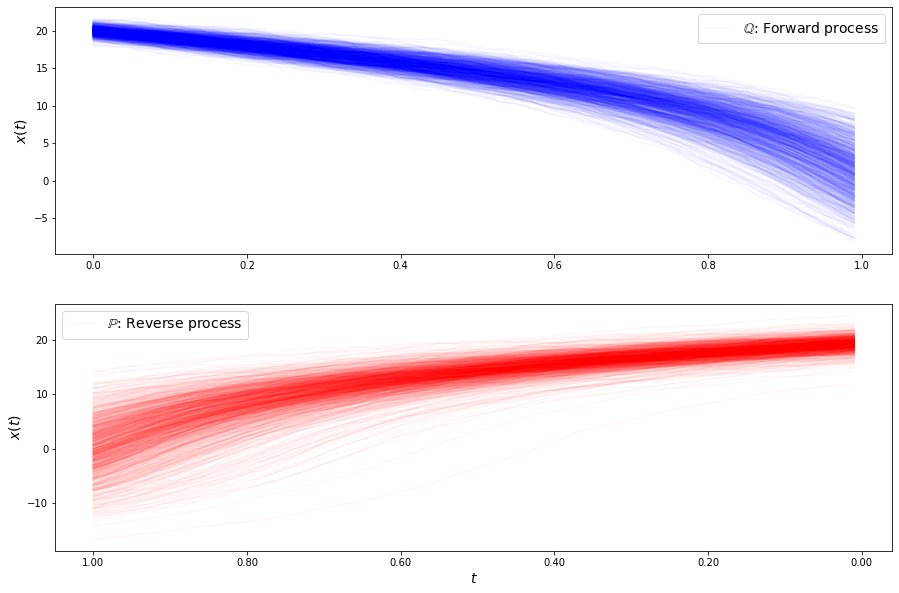

loss b 7.4245216751547645
loss b 7.1197773954806
loss b 6.86759141293582
loss b 7.097270282260546
loss b 6.595023379202158
loss b 6.579340682717472
loss b 6.5687657431988935
loss b 6.643948605255145
loss b 6.773689091948406
loss b 6.2125868547506045
loss b 6.433481153688548
loss b 6.738250498702307
loss b 6.547798567481818
loss b 6.3810489420338525
loss b 6.65515656304174
loss b 6.57493745184692
loss b 6.243277313244598
loss b 6.0265515724975485
loss b 6.285123640597228
loss b 6.115938870958641
loss b 5.692279650703953
loss b 5.637449648284521
loss b 5.564713128844899
loss b 5.958527442522874
loss b 6.08179523897972
loss b 6.313481117329804
loss b 5.998283433231083
loss b 5.99382350235235
loss b 6.225719896166067
loss b 6.207819860727273
loss f 2.298806074108523
loss f 2.322994726626079
loss f 2.315616380605703
loss f 2.307631186870706
loss f 2.344638356363203
loss f 2.2922545097849145
loss f 2.259071688504402
loss f 2.2935357872243376
loss f 2.269074479519135
loss f 2.368846395175426


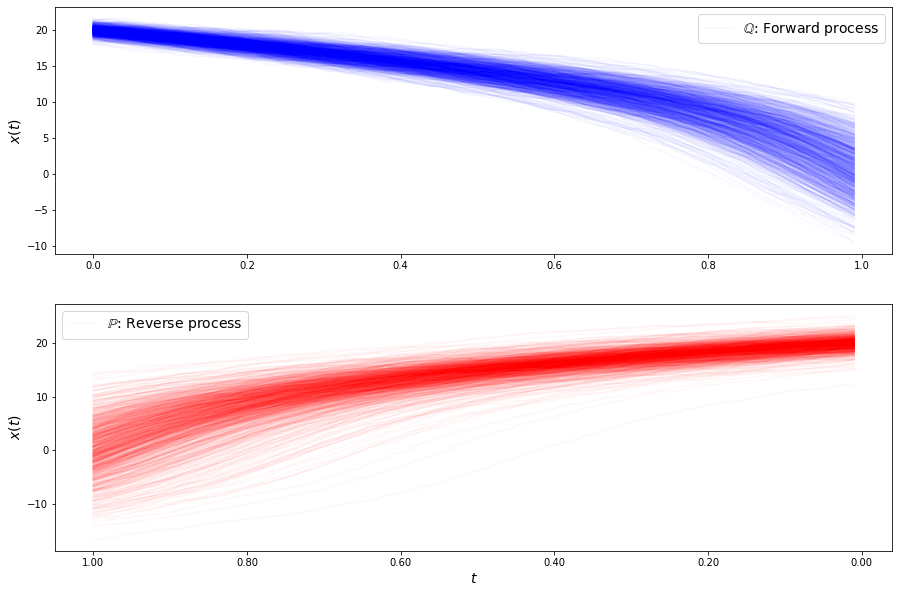

loss b 6.680675005457696
loss b 6.329907245289175
loss b 6.526411001129693
loss b 5.731190460303475
loss b 6.902317755312744
loss b 6.683302344351822
loss b 6.416146836712919
loss b 6.748051304517357
loss b 6.680207894552145
loss b 7.037862443553689
loss b 6.752489788873108
loss b 7.15303366385074
loss b 6.796190109900042
loss b 6.847666326721011
loss b 7.233254323486656
loss b 7.287462562878977
loss b 7.782908635904071
loss b 7.768401836737654
loss b 7.718335256481148
loss b 7.225339961394444
loss b 8.101735166029487
loss b 7.851138864133617
loss b 7.677693026683412
loss b 7.991327377873082
loss b 8.003440617009606
loss b 7.734773973390109
loss b 8.529184135091242
loss b 8.51646173242288
loss b 8.480384690878758
loss b 8.526257912368251
loss f 3.117684616270792
loss f 3.189192051478467
loss f 3.1095340554334854
loss f 3.010167002792528
loss f 3.057120815470767
loss f 3.017538273203418
loss f 3.093328064268256
loss f 3.175456568201355
loss f 3.0240986407930754
loss f 3.037163243772659


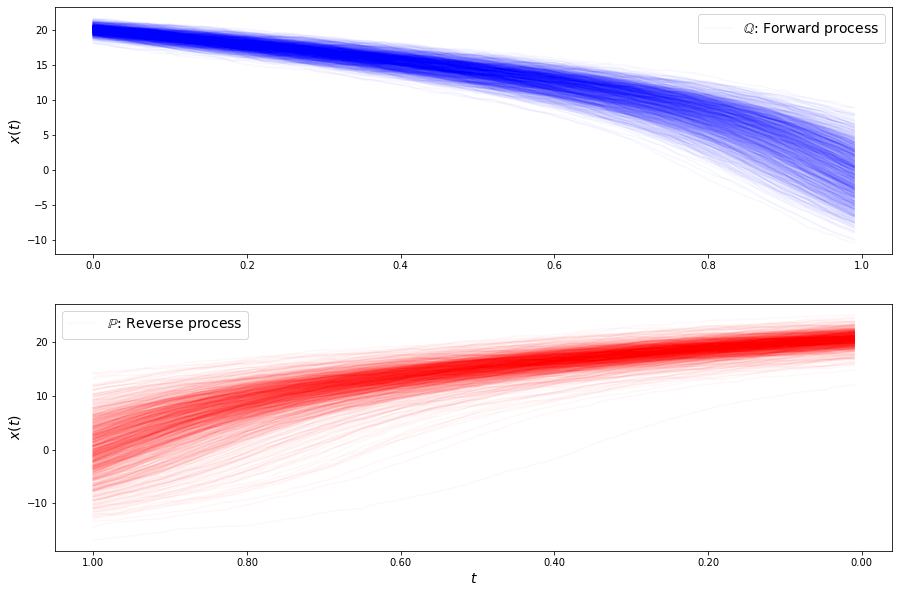

loss b 8.291035042113034
loss b 8.531582249607824
loss b 8.664773036864402
loss b 8.379292507160114
loss b 8.92211238877359
loss b 8.961507970287848
loss b 9.192081528028263
loss b 9.143946846468003
loss b 8.695422266721582
loss b 9.986721493029563
loss b 8.571756790070578
loss b 8.964984015842703
loss b 8.879571526453404
loss b 9.347831098071278
loss b 9.777170827892643
loss b 9.348739419918664
loss b 9.213428665181791
loss b 9.148582017353217
loss b 8.785685992802328
loss b 9.217301934281853
loss b 8.97522208120766
loss b 8.911777960089621
loss b 9.110713345783761
loss b 10.554160376958496
loss b 8.738568458678012
loss b 9.819106697386305
loss b 9.357150675154982
loss b 9.228881847380235
loss b 9.729050821001865
loss b 9.292906401522787
loss f 3.4134217468757573
loss f 3.414673895573917
loss f 3.4501405364086803
loss f 3.4693853176728244
loss f 3.3132887330711602
loss f 3.489256389511173
loss f 3.436447232823904
loss f 3.4032724693313705
loss f 3.432432612422275
loss f 3.396829273118

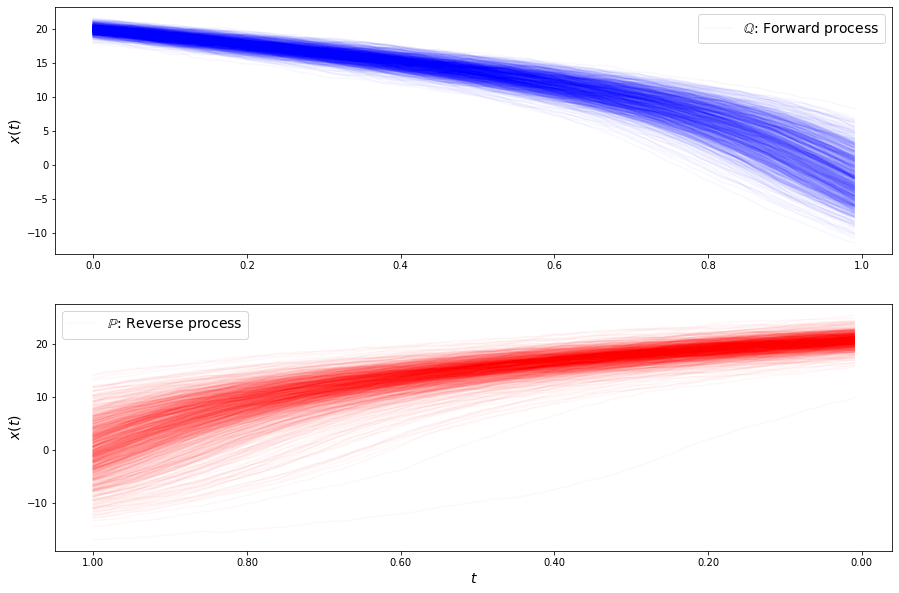

loss b 10.062070723755433
loss b 8.986738769674494
loss b 9.021638564457795
loss b 8.776521711915139
loss b 9.001179845633754
loss b 9.186000308802717
loss b 9.163025080536677
loss b 9.366566216012805
loss b 9.453406767285397
loss b 9.12438248045322
loss b 9.677745947922604
loss b 9.0836089071759
loss b 9.13647673144479
loss b 9.699948754384064
loss b 8.826591752755974
loss b 8.950484699827541
loss b 9.491612653583802
loss b 8.211308832617489
loss b 8.749678201645736
loss b 8.460976029303335
loss b 8.704488623072823
loss b 8.235604003569959
loss b 7.948024658552573
loss b 8.654925464416515
loss b 8.389668620011507
loss b 8.255023944497601
loss b 8.528961588680078
loss b 8.439493424197291
loss b 7.896083672206322
loss b 8.730637063798488
loss f 3.560436445902288
loss f 3.6387164601405253
loss f 3.5136440417604655
loss f 3.6090230920627717
loss f 3.607055756174487
loss f 3.647330328244659
loss f 3.777052106538938
loss f 3.740367297748064
loss f 3.6814341904048917
loss f 3.921919064674525

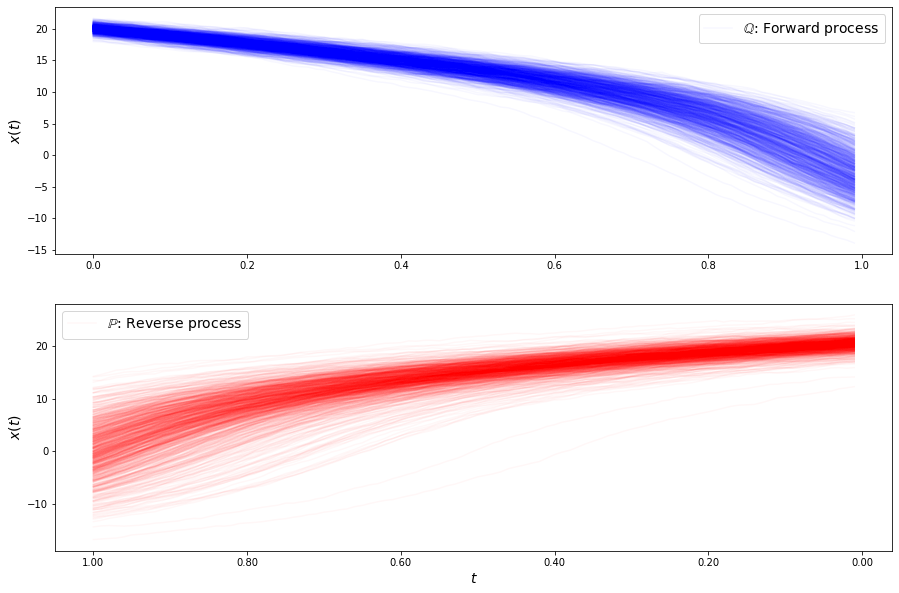

loss b 7.848292302816914
loss b 7.939195261709923
loss b 7.841851144356056
loss b 7.6528323467620805
loss b 8.246937159781561
loss b 8.475490871142275
loss b 7.90406006507903
loss b 7.736484862431886
loss b 7.769469354100661
loss b 7.761317813945846
loss b 7.77403811848117
loss b 7.633819026690957
loss b 7.331234660573898
loss b 7.908199531392082
loss b 7.930825853201753
loss b 7.802383305591431
loss b 8.07264521875932
loss b 7.896890413875639
loss b 7.60651585871093
loss b 8.05834770677676
loss b 8.028869973061822
loss b 7.5999104292160125
loss b 7.52613144093145
loss b 7.493932840372162
loss b 7.5777642845133455
loss b 7.267835393392854
loss b 7.384800412794438
loss b 7.497765821478411
loss b 7.208582639238953
loss b 7.282551845792787
loss f 4.378267914093038
loss f 4.456085207592258
loss f 4.435346518157268
loss f 4.462559597632863
loss f 4.451287298330388
loss f 4.545519862506649
loss f 4.521096217784833
loss f 4.548757815484471
loss f 4.394146375985377
loss f 4.5708515253587505
lo

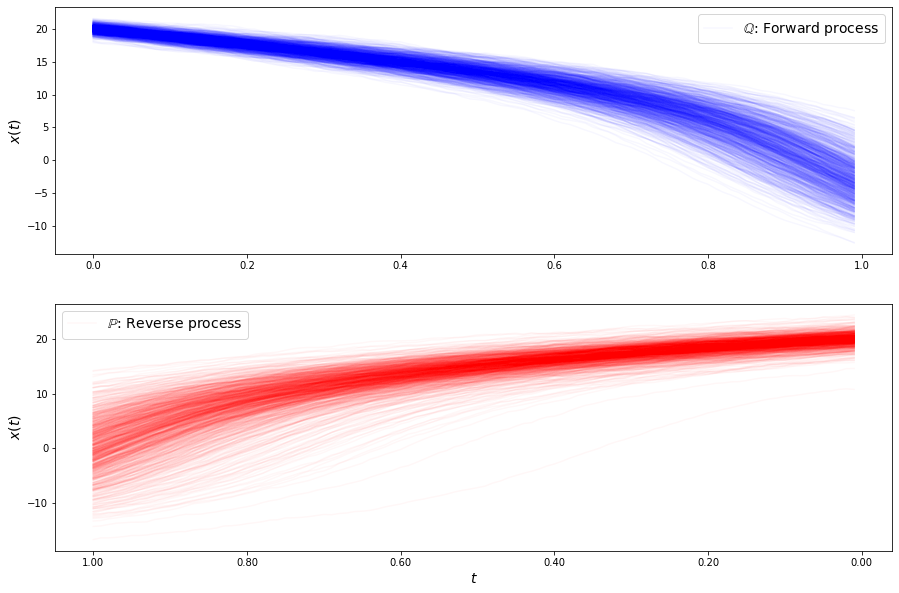

loss b 7.350714091556653
loss b 7.674709709210003
loss b 7.836848262187792
loss b 7.372114703832963
loss b 7.171526839279459
loss b 7.507208120907769
loss b 7.120677516835752
loss b 7.721348363756043
loss b 7.685070638955705
loss b 7.84490375516134
loss b 8.093366509342038
loss b 7.240773069254393
loss b 8.002986254238863
loss b 7.632026123970565
loss b 7.639385266511932
loss b 8.173855363823796
loss b 7.827352648133947
loss b 7.632358980669627
loss b 7.721282023050352
loss b 7.920595425710344
loss b 7.350652719441995
loss b 7.739779972772652
loss b 8.026480137208303
loss b 8.046570165587182
loss b 7.7961723882408105
loss b 7.780357602437264
loss b 7.824443287774977
loss b 7.913034531613959
loss b 7.482473571381226
loss b 8.018434270443876
loss f 4.977929581701166
loss f 5.021639327594241
loss f 4.890294763387337
loss f 4.948085624286847
loss f 4.855456778197204
loss f 4.86226248967446
loss f 4.797799043680025
loss f 4.822970453592038
loss f 4.653625288709082
loss f 4.753273264814568
l

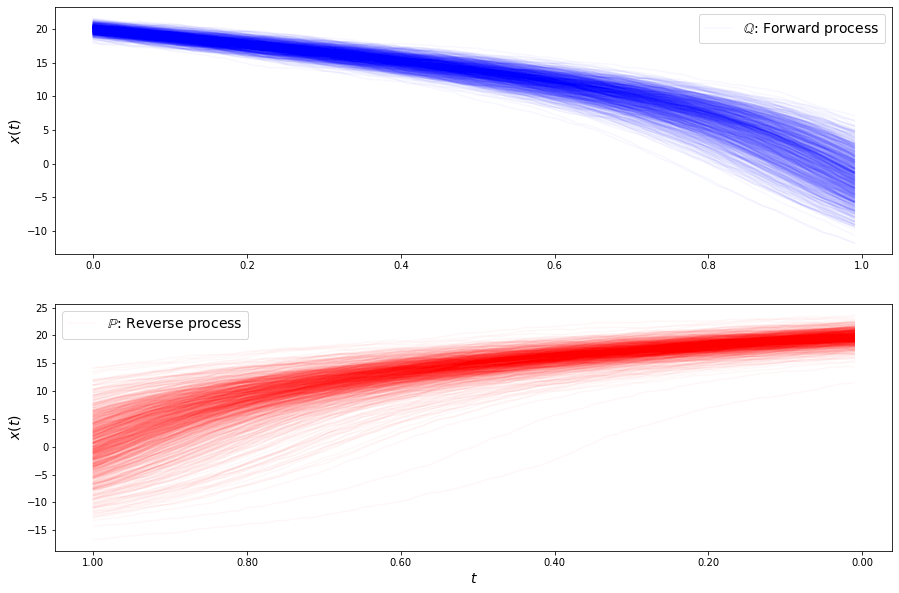

loss b 7.659944516619338
loss b 7.530944235775734
loss b 7.212225291393046
loss b 7.656340029192943
loss b 7.101269874625901
loss b 7.2608367975774275
loss b 7.411738997598063
loss b 7.259313130911737
loss b 7.263793603900163
loss b 7.266914383778181
loss b 7.600138026570899
loss b 7.382707180722478
loss b 7.3468081464628225
loss b 7.7320454586319105
loss b 8.339697452750286
loss b 7.37927010536034
loss b 7.648164381362097
loss b 7.391576238185567
loss b 8.272981456833737
loss b 7.424538411482081
loss b 7.387698845766421
loss b 7.165796182613804
loss b 7.290223627652803
loss b 7.460260392554029
loss b 7.6732550249886495
loss b 7.467279575548724
loss b 7.349047006023057
loss b 7.815942820385427
loss b 7.610881298252679
loss b 7.917584866337257
loss f 4.288065173386892
loss f 4.438494712972632
loss f 4.321404873923297
loss f 4.228701110721963
loss f 4.181501530003214
loss f 4.064867111977811
loss f 4.055279261836408
loss f 4.124010232781189
loss f 4.0298843161229705
loss f 3.986286097646

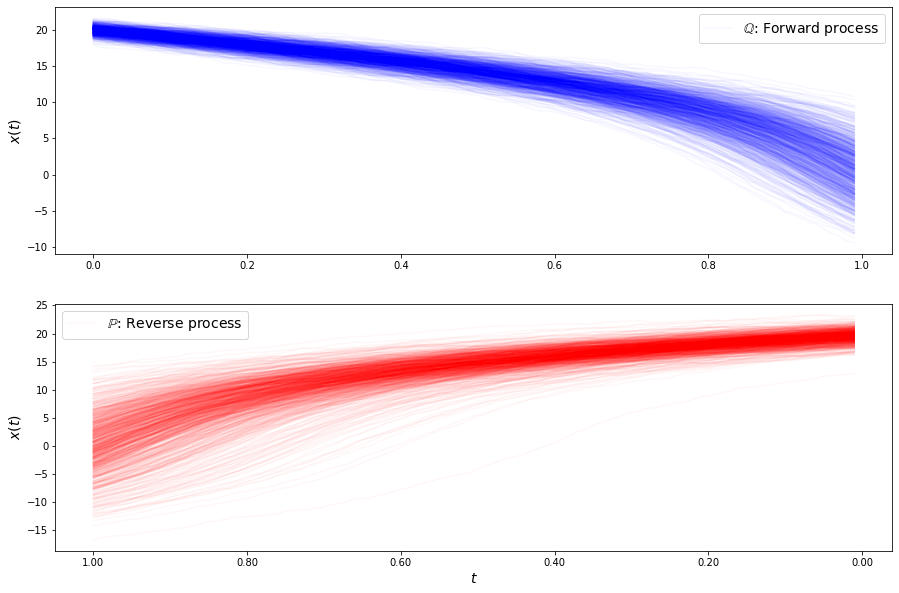

loss b 7.001461980848676
loss b 7.093626843607786
loss b 6.950595881319329
loss b 7.054562367971255
loss b 7.182556243387039
loss b 6.916400023916381
loss b 6.369426421726951
loss b 6.566641169860685
loss b 7.284899300263022
loss b 7.007068352933566
loss b 6.990713335259148
loss b 7.19922567456665
loss b 7.044878771400789
loss b 6.7494406891066605
loss b 6.895990799233818
loss b 7.159060424530267
loss b 6.914340183891184
loss b 7.487195798214072
loss b 7.223430239707847
loss b 6.928484799328905
loss b 6.941386321699663
loss b 7.286807894928045
loss b 7.034578836171483
loss b 6.987713342176598
loss b 6.81986610445788
loss b 6.5464465978088935
loss b 7.201303273734484
loss b 7.1766369051121295
loss b 7.309189663322241
loss b 6.901946125497766
loss f 3.3902589263855294
loss f 3.4400003977402216
loss f 3.353327502597131
loss f 3.310514771546656
loss f 3.316923810816694
loss f 3.37424148137657
loss f 3.234114024379323
loss f 3.312450182421404
loss f 3.207854597040561
loss f 3.25112920261502

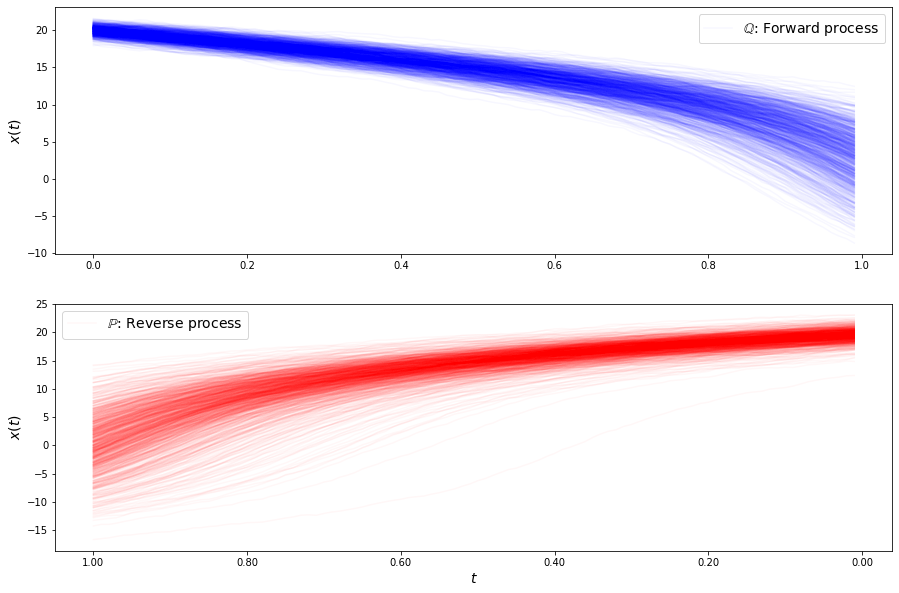

loss b 7.257410862720147
loss b 7.057586178553146
loss b 7.093793863248341
loss b 6.678813000615141
loss b 6.935663473438046
loss b 6.964255320972089
loss b 7.208344657336787
loss b 6.426832032644381
loss b 6.938051751860577
loss b 6.8309023927822015
loss b 6.8339743953333
loss b 7.138268220708576
loss b 7.047182611823353
loss b 6.8644743580695
loss b 7.070179870792546
loss b 7.157813582633068
loss b 7.0343179981185555
loss b 6.62797657126781
loss b 6.823934446771861
loss b 6.71965360119224
loss b 7.033502716826356
loss b 6.73117611858463
loss b 6.648723853823024
loss b 6.711163510611111
loss b 7.08227576113434
loss b 7.047360178001446
loss b 7.892981046669867
loss b 6.817940679169777
loss b 7.102534398603296
loss b 6.976827972788017
loss f 3.3763252414526415
loss f 3.3220202919941566
loss f 3.3616763439527433
loss f 3.385660875370775
loss f 3.402650505070132
loss f 3.4345615480163736
loss f 3.483902928134377
loss f 3.405121507361983
loss f 3.468178285452126
loss f 3.4926352042752233
l

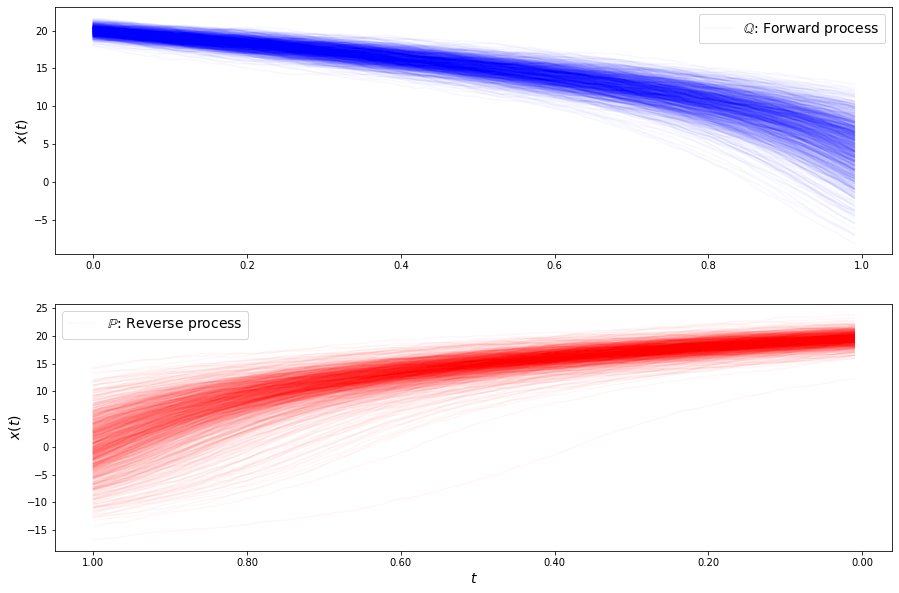

loss b 7.376955664335667
loss b 7.590048205330287
loss b 7.22526081584584
loss b 7.635726615031047
loss b 7.543725413850669
loss b 7.55047226938417
loss b 7.273095978857479
loss b 7.066239599974834
loss b 7.458773275027285
loss b 7.136065125253092
loss b 7.724883569183825
loss b 7.414379822326319
loss b 7.073701170048718
loss b 7.134997647909595
loss b 7.442547661288519
loss b 7.015520900161465
loss b 6.868818214894852
loss b 7.418723739253019
loss b 7.005908846475081
loss b 7.36383116854035
loss b 7.3391986156131335
loss b 7.005204438424642
loss b 7.12491589813834
loss b 7.482106734032337
loss b 7.166658123954523
loss b 7.499361958218669
loss b 7.337890167929861
loss b 7.198902542325512
loss b 6.887702977931719
loss b 7.161804660111595
loss f 3.998038983752453
loss f 4.002654568714235
loss f 4.004287393252935
loss f 3.9782791438491163
loss f 3.962808966396911
loss f 4.066082174862157
loss f 4.081013951167261
loss f 4.041734436510883
loss f 4.096216646981356
loss f 4.148935355287569
lo

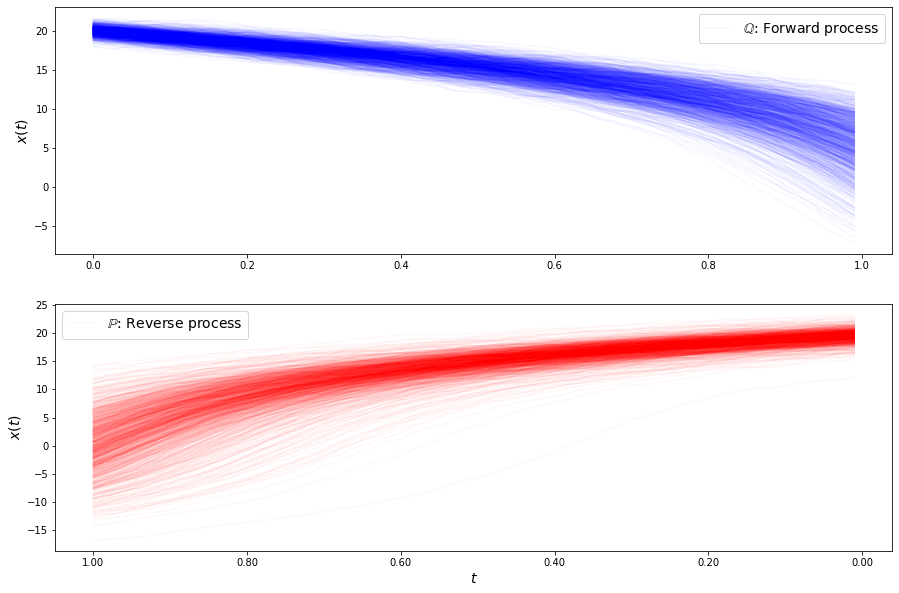

loss b 7.151385829309741
loss b 7.725677505637658
loss b 7.631192867073013
loss b 7.465972827053724
loss b 7.382734925107346
loss b 7.5233342124574225
loss b 7.448728167084281
loss b 7.50314304175416
loss b 7.707919060704795
loss b 7.519144921403205
loss b 7.604534591991925
loss b 7.5215916520586275
loss b 7.403536396451547
loss b 7.463636546956677
loss b 7.459628295553156
loss b 7.086468643318373
loss b 7.391687821291869
loss b 7.241367972953401
loss b 7.6675941340203675
loss b 7.543989134732142
loss b 7.370967517087172
loss b 7.501640133093343
loss b 7.474272750500454
loss b 7.465725236895527
loss b 7.628580940901731
loss b 7.139018246892729
loss b 7.7107791394525265
loss b 7.234208551774742
loss b 7.472839556235893
loss b 6.824322045426777
loss f 4.182437243267738
loss f 4.253967342444035
loss f 4.229276341581535
loss f 4.213596029948695
loss f 4.2167023216412485
loss f 4.109244822226199
loss f 4.195855223914029
loss f 4.166680771563954
loss f 4.121660398485564
loss f 4.184911159933

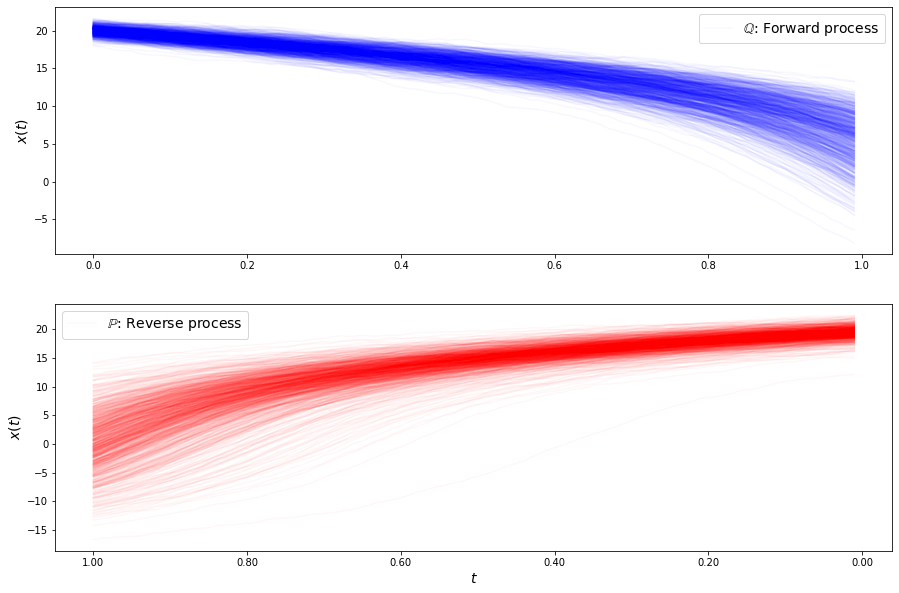

loss b 6.842252867498333
loss b 7.123933434766693
loss b 7.077696407014976
loss b 6.894603805088211
loss b 6.77066259536808
loss b 7.189561294186108
loss b 6.946230387118651
loss b 6.981126546683126
loss b 6.844297472569802
loss b 7.175658830800195
loss b 7.232957206770005
loss b 6.992106504171771
loss b 6.828913039296704
loss b 6.862701475393524
loss b 7.015949514441005
loss b 6.857135763235947
loss b 6.994639793766464
loss b 7.170627134074753
loss b 7.015402630205025
loss b 6.8910776117922925
loss b 7.110085317104171
loss b 7.094977177772023
loss b 7.126339703375861
loss b 6.475576741237738
loss b 7.1175768155543215
loss b 7.071961137816687
loss b 7.160670711884152
loss b 7.192768803588726
loss b 6.977263261034202
loss b 7.098972465237039
loss f 3.867772737216831
loss f 3.6964211143395698
loss f 3.8244170550584684
loss f 3.7128588864026653
loss f 3.697974560214414
loss f 3.7264762140147987
loss f 3.6861732613978924
loss f 3.633380463522468
loss f 3.6306373491769417
loss f 3.572553971

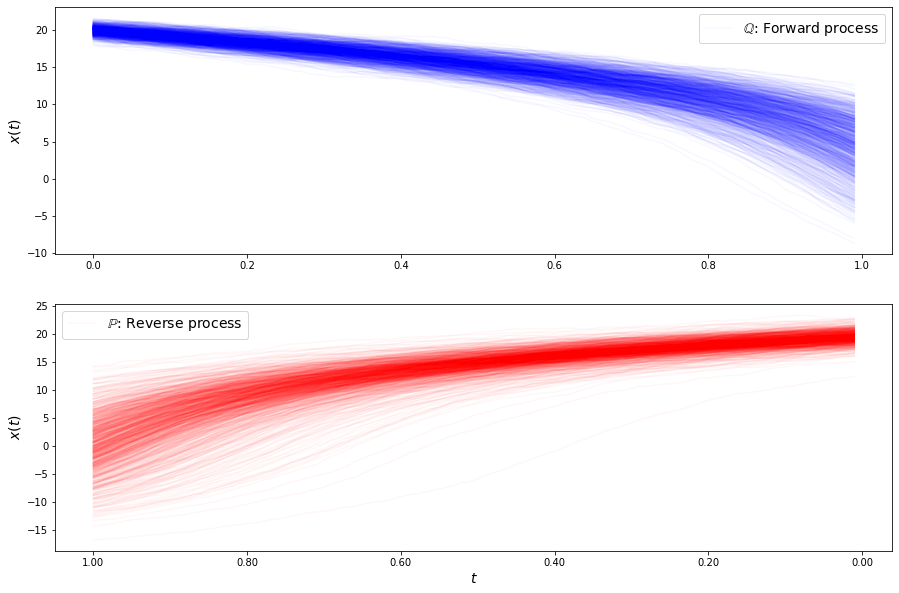

loss b 6.290565387929482
loss b 6.543788414370631
loss b 6.68670368993808
loss b 6.506657813132687
loss b 6.275405956763707
loss b 6.185876163219207
loss b 6.388886712150842
loss b 5.993664524643199
loss b 6.661044925282387
loss b 6.432291581358007
loss b 6.720729748595962
loss b 6.601340184322623
loss b 6.78774187000774
loss b 6.690925009277447
loss b 6.5246003321189985
loss b 6.34995918694173
loss b 6.564008923105429
loss b 6.641605704170942
loss b 6.259063108433334
loss b 6.415878544003755
loss b 6.79663889347051
loss b 6.856096416712058
loss b 6.482450481454196
loss b 6.369444788169541
loss b 6.498927418910356
loss b 6.994243176116591
loss b 6.621697737470828
loss b 6.472301197125775
loss b 6.3246185217104856
loss b 6.811302587487137
loss f 3.0665546094148626
loss f 3.0931365690483164
loss f 2.9381999156800105
loss f 3.0332029374159446
loss f 2.9836845439767417
loss f 3.023397450319808
loss f 2.862113403840925
loss f 2.9009784440122726
loss f 2.8844041509767377
loss f 2.93028489685

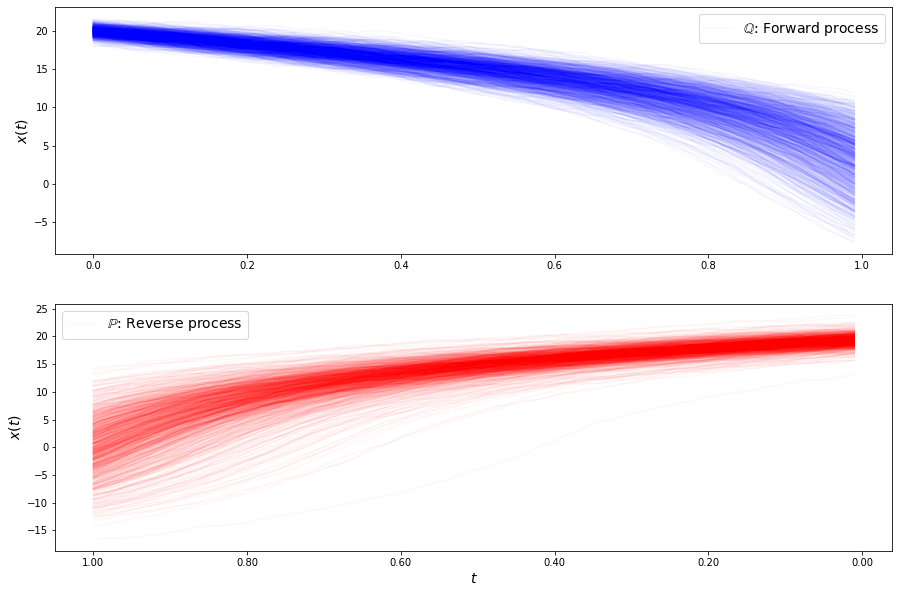

loss b 6.294303193788042
loss b 6.120461666409644
loss b 6.25742481029393
loss b 6.434285363472036



KeyboardInterrupt: 

In [9]:


torch.autograd.set_detect_anomaly(True)
c.fit(150, 30, burn_iterations=0, plot=True)

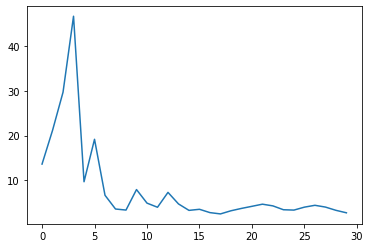

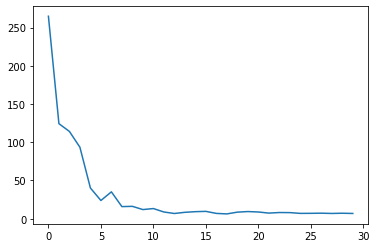

In [11]:
plt.plot(c.loss_f[0:])
plt.show()
plt.plot(c.loss_b[0:])

In [12]:
bb = lambda X: -c.b_backward(X)

t, Xts = c.sde_solver(
    c.b_forward.forward, c.sigma,
    c.X_0, c.dt,  c.number_time_steps, 0.0,
    c.theta_f, False, True
)
t_, Xts_ = c.sde_solver(
    bb, c.sigma, 
    c.X_1, c.dt, c.number_time_steps, 0.0, 
    c.theta_b, False, False
)

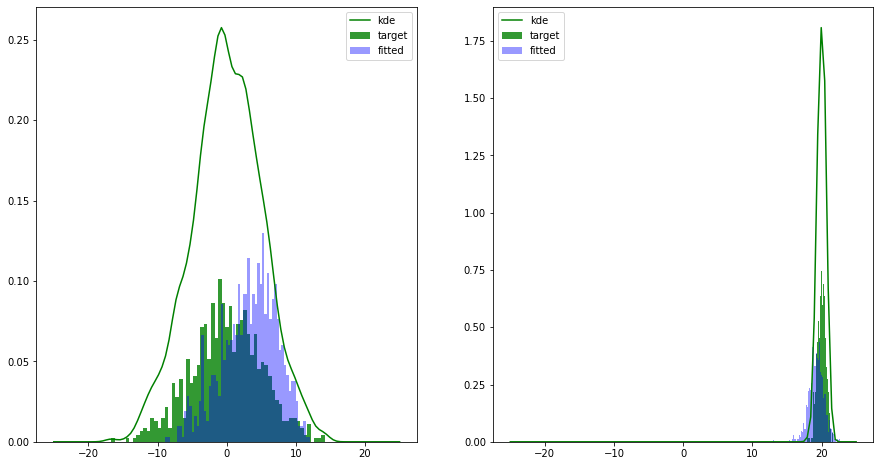

In [13]:
fig, axs = plt.subplots(1,2, figsize=(15, 8))
batch_terminal_empirical_f = next(c.data_stream(forward=True))
xx = torch.linspace(-25, 25).reshape(-1,1).cuda().double()

H = silvermans_rule(batch_terminal_empirical_f)
kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, H).detach().cpu().numpy())
axs[1].plot(xx.detach().cpu().numpy(), kd, label="kde", color="green")


bins = 60
axs[1].hist(( X1.detach().cpu().numpy().flatten()), alpha=0.8, bins=bins, label="target", density=True, color="green");
axs[1].hist(( Xts_[:,-1,:-1].flatten().detach().cpu().numpy()), alpha=0.4, bins=bins, label="fitted", density=True, color="blue");
axs[1].legend()




batch_terminal_empirical_b = next(c.data_stream(forward=False))
# xx = torch.linspace(-10, 10).reshape(-1,1).cuda().double()

Hb = silvermans_rule(batch_terminal_empirical_b)
kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, Hb).detach().cpu().numpy())
axs[0].plot(xx.detach().cpu().numpy(), kd, label="kde", color="green")


bins = 60
axs[0].hist(( X2.detach().cpu().numpy().flatten()), alpha=0.8, bins=bins, label="target", density=True, color="green");
axs[0].hist(( Xts[:,-1,:-1].flatten().detach().cpu().numpy()), alpha=0.4, bins=bins, label="fitted", density=True, color="blue");
axs[0].legend()